In [1]:
import tensorflow as tf
import numpy as np

2023-09-06 18:23:53.504929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="mouse_model.tflite")
interpreter.resize_tensor_input(0, [1, 640, 640, 3])




2023-09-06 18:50:17.927049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-06 18:50:17.927082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
interpreter.get_input_details()

[{'name': 'serving_default_input_tensor:0',
  'index': 0,
  'shape': array([1, 1, 1, 3], dtype=int32),
  'shape_signature': array([ 1, -1, -1,  3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [3]:
interpreter.get_input_details()

[{'name': 'serving_default_input_tensor:0',
  'index': 0,
  'shape': array([1, 1, 1, 3], dtype=int32),
  'shape_signature': array([ 1, -1, -1,  3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [3]:
signature_fn = interpreter.get_signature_runner()

In [4]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['input_tensor'],
  'outputs': ['detection_anchor_indices',
   'detection_boxes',
   'detection_classes',
   'detection_multiclass_scores',
   'detection_scores',
   'num_detections',
   'raw_detection_boxes',
   'raw_detection_scores']}}

In [5]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'serving_default_input_tensor:0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([ 1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:6', 'index': 438, 'shape': array([    1, 51150,     4], dtype=int32), 'shape_signature': array([    1, 51150,     4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 588, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales':

In [57]:
import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['mouse'] 


# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(input_tensor=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['num_detections']))
  scores = np.squeeze(output['detection_scores'])
  classes = np.squeeze(output['detection_classes'])
  boxes = np.squeeze(output['detection_boxes'])

  results = []
  
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    # color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [7]:
image = Image.open("Screenshot 2023-04-19 at 1.55.45 PM.png")
image.size

(2784, 1664)

In [7]:
imagepath = "Screenshot 2023-04-19 at 1.55.45 PM.png"

In [16]:
out = run_odt_and_draw_results(imagepath, interpreter, threshold=0.95)

In [51]:
cv2.imshow("yo", out)

: 

In [12]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 526.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.5 MB/s eta 0:00:00a 0:00:01m
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_10_9_x86_64.whl (65 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [63]:
from matplotlib import pyplot as plt

In [2]:
interpreter = tf.lite.Interpreter(model_path="mouse_model.tflite")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



INFO: Created TensorFlow Lite delegate for select TF ops.
2023-09-06 18:24:29.465986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 18:24:29.466699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-06 18:24:29.466753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 368 nodes with 0 parti

In [5]:
import cv2

In [15]:
interpreter.allocate_tensors()

In [16]:
interpreter.resize_tensor_input(0, [1, 640, 640, 3])

In [67]:
test_image=cv2.imread(imagepath)
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
img = tf.image.convert_image_dtype(gray, tf.uint8)
original_image = img
resized_img = tf.image.resize(img, (640,640))
resized_img = resized_img[tf.newaxis, :]
resized_img = tf.cast(resized_img, dtype=tf.uint8)
results = detect_objects(interpreter, resized_img, 0.8)

In [68]:
# Plot the detection results on the input image
original_image = test_image
original_image_np = original_image.astype(np.uint8)
for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

# Find the class index of the current object
class_id = int(obj['class_id'])

# Draw the bounding box and label on the image
# color = [int(c) for c in COLORS[class_id]]
cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

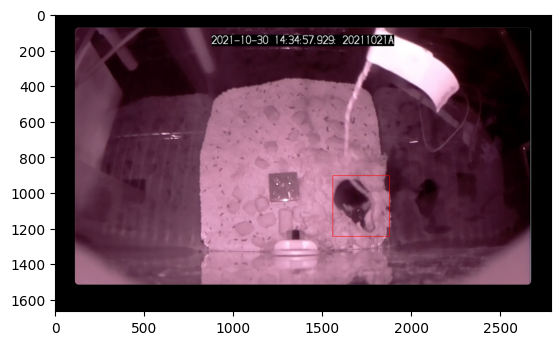

In [69]:
plt.imshow(original_image_np)

In [59]:
results

[{'bounding_box': array([0.04562951, 0.24724217, 0.23101252, 0.39967537], dtype=float32),
  'class_id': 1.0,
  'score': 0.8964982}]

In [19]:
output_details = interpreter.get_output_details()

In [23]:
output_details

[{'name': 'StatefulPartitionedCall:6',
  'index': 438,
  'shape': array([    1, 51150,     4], dtype=int32),
  'shape_signature': array([    1, 51150,     4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:0',
  'index': 588,
  'shape': array([  1, 100], dtype=int32),
  'shape_signature': array([ 1, -1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:5',
  'index': 553,
  'shape': array([1], dtype=int32),
  'shape_signature': array([1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': arr

In [22]:
interpreter.get_tensor(output_details[0])

TypeError: GetTensor(): incompatible function arguments. The following argument types are supported:
    1. (self: tensorflow.lite.python.interpreter_wrapper._pywrap_tensorflow_interpreter_wrapper.InterpreterWrapper, tensor_index: int, subgraph_index: int = 0) -> object

Invoked with: <tensorflow.lite.python.interpreter_wrapper._pywrap_tensorflow_interpreter_wrapper.InterpreterWrapper object at 0x1961c91b0>, {'name': 'StatefulPartitionedCall:6', 'index': 438, 'shape': array([    1, 51150,     4], dtype=int32), 'shape_signature': array([    1, 51150,     4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, 0

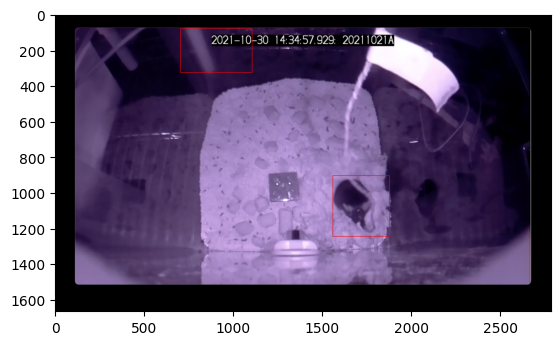

In [17]:
plt.imshow(out)

In [7]:
interpreter.get_input_details()[0]['shape']

array([1, 1, 1, 3], dtype=int32)